# SoMA DIS Demo

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

## Introduction

In this notebook, we will demonstrate how to use the [`censusdis`](https://github.com/vengroff/censusdis) package 
to download some US Census data and then how to use the [`divintseg`](https://github.com/vengroff/divintseg) package 
to compute some diversity and integration metrics.

In this example, we will look at US Census redistricting data from the towns of South Orange
and Maplewood (collectively known as SoMa) in Essex County,
NJ. We chose redistricting data because it has the demographic data we are interested in
studying, including race and ethnicity.

Once you are familiar with the API and how to use it, you can easily experiment with
similar analysis of the area where you live.

## Environment Setup

We assume you are running this notebook in an environment where the necessary 
packages have been `pip` installed. You should be able to get everything you
need with just 

```
pip install censusdis
```

which will also install `divintseg` and various other dependencies.

## Imports

We need to import out resistricting data API, some utilities for getting map data, and the 
[`divintseg`](https://github.com/vengroff/divintseg) 
package that computes diversity and integration metrics, along with `pandas` for some basic data
manipulation.

In [2]:
import censusdis.data as ced

from censusdis.states import STATE_NJ

import divintseg as dis

import pandas as pd

## US Census API Key

The US Census API uses a key to identify callers. If you don't already have a key, you can request
one [here](https://api.census.gov/data/key_signup.html). Please put your key into this cell before 
running the notebook.

For small queries like in this demo notebook, the API seems to work without a key, so you can leave
it set to `None`, but for more serious work you will want to obtain a key.

In [3]:
CENSUS_API_KEY = None

## Basic Configuration

### Year

US Cansus data is organized by the year it was collected. For the moment, we
are interested in the year 2020.

In [4]:
YEAR = 2020

### Dataset

In any given year, the US Census publishes a wide variety of data, which 
comes in different
collections called datasets. A dataset typically consists of a wide
variety of data gathered at the same time using the same methodology.

A high-level summary of the datasets published in 2020  
can be found at https://api.census.gov/data/2020.html.

The dataset we are interested in using is called the 
[Decennial Census: Redistricting Data (PL 94-171)](https://www.census.gov/programs-surveys/decennial-census/about/rdo/summary-files.html).

In code is commonly known as `dec/pl`, which is how we will refer to it here.

In [5]:
DATASET = "dec/pl"

### Group

A group is a set of related variables within a dataset.
Groups cover all kinds of
topics. We are using 2020 `dec/pl` 
redistricting data, so the groups available are those summarized 
at https://api.census.gov/data/2020/dec/pl/groups.html. 
Notice how the URL just keeps buidling up as we go from year to 
dataset to group.

Don't worry
if nothing on that page means anything to you right now. We'll explain it
here.

If we choose P1, then the data is grouped purely based on race, 
not taking ethnicity into account at all. If we choose P2, then the data is
first grouped by ethnicity, with people reporting Hispanic or Latino ethinicity
put into one group regardless of their race. Everyone else is then divided into
groups based on their race.

Thus, P2 has one group that P1 does not have, which is Hispanic or Latino of 
any race. In the P1 data set, people who are in the Hispanic or Latino group 
in P2 are instead classified into one of the race-based groups. 

For more information, including additional options P3 and P4, see this
additional 
[documentation](https://www.census.gov/programs-surveys/decennial-census/about/rdo/summary-files.html).

In [6]:
GROUP = "P2"

### Variables

The variables in many groups
exist in tree-structured hierarchy. We can see the hierarchy for our gropu by 
looking at the
labels in the second column of the table at 
https://api.census.gov/data/2020/dec/pl/groups/P2.html

We are most interested in the leaves of this tree, which are the
populations of people that are not further subdivided. P2_002N is 
a leaf because the population that is Hispanic or Latino is not
further subdivided. P2_003N is not a leaf, because it is further
subdivided into P2_004N and P2_011N.

Luckily, we don't have to read through the table of variables in
the group and carefully keep track of what are leaves and what 
aren't. Instead, we can make a single call to find the leaf 
variables in the group.

In [7]:
leaves = ced.variables.group_leaves(DATASET, YEAR, GROUP)

If you start looking the first ten or so fields up in in the table at https://api.census.gov/data/2020/dec/pl/groups/P2.html you 
should be able to convince yourself that we successfully found
the leaves. Note that there are also annotation fields listed 
in the table, but the API we used skipped those by default.

In [8]:
leaves[:10]

['P2_002N',
 'P2_005N',
 'P2_006N',
 'P2_007N',
 'P2_008N',
 'P2_009N',
 'P2_010N',
 'P2_013N',
 'P2_014N',
 'P2_015N']

## South Orange and Maplewood Tracts in Essex County, NJ

Now that we know what variables we are interested in, we want to get data for them from 
the towns of South Orange and Maplewood (collectively known as SoMa) in Essex County,
NJ. 

### Essex County

For Essex County, we found the code `'013`' on this 
[wikipedia page](https://en.wikipedia.org/wiki/List_of_counties_in_New_Jersey).

In [9]:
COUNTY_ESSEX_NJ = "013"

### SoMa Tracts

We found the tracts that make up the two towns by looking
at 
[this map](https://www2.census.gov/geo/maps/dc10map/tract/st34_nj/c34013_essex/DC10CT_C34013_002.pdf).
We format them as strings using the convention of
Census API, which is a six-digit string.

In [10]:
tracts_soma = [f"{t:06}" for t in range(19000, 20000, 100)]
tracts_soma

['019000',
 '019100',
 '019200',
 '019300',
 '019400',
 '019500',
 '019600',
 '019700',
 '019800',
 '019900']

### SoMa Data Query

Now we can query the data. See the inline comments for descriptions of the various
arguments we pass.

The return value will be a `pd.DataFrame` containing a row for each block (the resolution we specified). In order to make
analysis of diversity and integration at various levels of geographic aggregation easier (e.g. using the 
[divintseg](https://github.com/vengroff/divintseg) package) the identifiers of all of the nested geographies from the 
state down to the block are included in each row. In this case that means we have columns for STATE, COUNTY, TRACT, BLOCK_GROUP,
and BLOCK. After these columns, we have one column for each of the demographic fields we asked for.

In [11]:
df_soma = ced.download(
    # First we specify the dataset and year:
    DATASET,
    YEAR,
    # Next, the variables we want to get data for:
    leaves,
    # Next come filters that constrain what data we
    # want to load, specified as keyword arguments.
    # The narrowest of these, which in our case is
    # block, specifies the level of aggregation. We
    # use block=* to indicate all blocks within the
    # tracts we have specified.
    state=STATE_NJ,
    county=COUNTY_ESSEX_NJ,
    tract=tracts_soma,
    block="*",
    # Finally, we put in our API key:
    api_key=CENSUS_API_KEY,
)

In [12]:
df_soma

,STATE,COUNTY,TRACT,BLOCK,P2_002N,P2_005N,P2_006N,P2_007N,P2_008N,P2_009N,...,P2_062N,P2_063N,P2_064N,P2_066N,P2_067N,P2_068N,P2_069N,P2_070N,P2_071N,P2_073N
0,34,013,019400,1004,3,39,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34,013,019400,1005,7,78,8,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,34,013,019400,1006,1,57,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,34,013,019400,1007,1,9,4,0,8,0,...,0,0,0,0,0,0,0,0,0,0
4,34,013,019400,1008,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,34,013,019900,2007,3,113,3,0,6,0,...,0,0,0,0,0,0,0,0,0,0
513,34,013,019900,2010,3,26,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
514,34,013,019900,3001,2,70,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
515,34,013,019900,3005,6,49,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0


## Compute Diversity and Integration

Now that we have the census data telling us how many people of each group there are
in each block of SoMa, we can calculate diversity and inclusion at the tract over
block level. For a detailed explination of what we are actually calculating here, see
the [README.md](https://github.com/vengroff/divintseg/blob/main/README.md) in the 
[divintseg package](https://github.com/vengroff/divintseg).

In [13]:
df_soma_dis = dis.di(df_soma, by=["STATE", "COUNTY", "TRACT"], over="BLOCK")
df_soma_dis = df_soma_dis.reset_index()

df_soma_dis

,STATE,COUNTY,TRACT,diversity,integration
0,34,013,019000,0.543067,0.512476
1,34,013,019100,0.652714,0.546923
2,34,013,019200,0.647694,0.615236
3,34,013,019300,0.618209,0.579605
4,34,013,019400,0.365888,0.345998
5,34,013,019500,0.437986,0.410561
6,34,013,019600,0.668206,0.583210
7,34,013,019700,0.586909,0.527381
8,34,013,019800,0.538240,0.458679
9,34,013,019900,0.373448,0.353460


## Plot on a map

Now that we have the geometry of each census tract, we can ask `censusdis`
to infer the geography level the data frame represents (census tract in this case)
and add a geometry column for each tract so we can plot them. The results 
are returned in a `GeoDataFrame`.

### Infer geometry

In [14]:
gdf_essex_di = ced.add_inferred_geography(df_soma_dis, YEAR)

In [15]:
gdf_essex_di

,STATE,COUNTY,TRACT,diversity,integration,geometry
0,34,013,019000,0.543067,0.512476,"POLYGON ((-74.28311 40.74787, -74.28183 40.749..."
1,34,013,019100,0.652714,0.546923,"POLYGON ((-74.26099 40.75272, -74.26070 40.753..."
2,34,013,019200,0.647694,0.615236,"POLYGON ((-74.26127 40.73672, -74.26020 40.738..."
3,34,013,019300,0.618209,0.579605,"POLYGON ((-74.27213 40.74294, -74.26845 40.744..."
4,34,013,019400,0.365888,0.345998,"POLYGON ((-74.29251 40.75379, -74.29214 40.756..."
5,34,013,019500,0.437986,0.410561,"POLYGON ((-74.27240 40.72971, -74.27182 40.731..."
6,34,013,019600,0.668206,0.583210,"POLYGON ((-74.26103 40.72748, -74.25869 40.730..."
7,34,013,019700,0.586909,0.527381,"POLYGON ((-74.27240 40.72030, -74.27113 40.720..."
8,34,013,019800,0.538240,0.458679,"POLYGON ((-74.28533 40.72272, -74.28234 40.722..."
9,34,013,019900,0.373448,0.353460,"POLYGON ((-74.28836 40.73679, -74.28624 40.739..."


### Plot the Maps

Now we can plot diversity and integration as heat maps. We did just some 
very basic styling on these plots, but of course you can do whatever you
want to make them the best visualizions for your purposes.

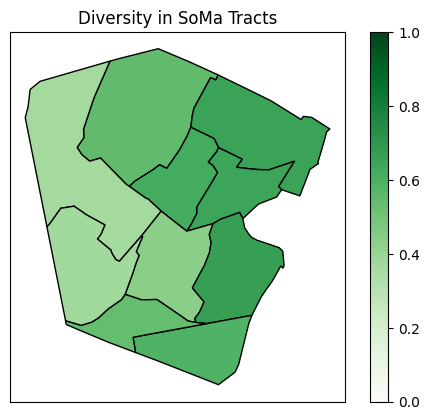

In [16]:
ax = gdf_essex_di.plot(
    "diversity",
    cmap="Greens",
    edgecolor="black",
    legend=True,
    vmin=0.0,
    vmax=1.0,
)

ax.set_title("Diversity in SoMa Tracts")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)

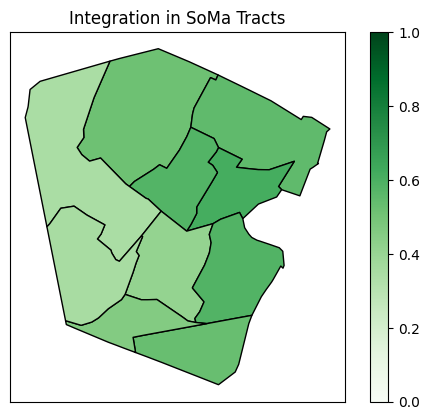

In [17]:
import matplotlib.pyplot as plt

ax = gdf_essex_di.plot(
    "integration",
    cmap="Greens",
    edgecolor="black",
    legend=True,
    vmin=0.0,
    vmax=1.0,
)

ax.set_title("Integration in SoMa Tracts")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)